Chapter 1
======
***

Bayesian inference is simply updating your beliefs after considering new evidence.
Bayesians interpret probability as a measure of confidence in an event occuring.
Conversely, a frequentist interprets probability as the frequency of events.

Consider flipping an unfair coin. It lands heads.

** Bayesian**: The data is fixed (the coin landed heads). The parameters (the probability that the coin landed heads) are random.

** Frequentist**: The parameters are fixed. The result is a random variable, a single trial sampling from a probability distribution with a fixed, unknown heads  probability

In the Bayesian approach, we start with a *prior* belief about the probability of event $A$, $P(A)$. Given some evidence $X$, we then update our belief as $P(A|X)$. This approach includes our prior belief in an event occuring. As more evidence is aquired, our prior belief is washed out.
Suppose we have a number of instances of evidence $N$. For $N \rightarrow \infty$, the Bayesian and frequentist results will align. Any inference made can be easily and objectively agreed upon. On the other hand, for small $N$ inference is muc more unstable - frequentist estimates have greter variance and larger confidence intervals. This is where Bayesian analyis excels; by starting with a prior and updating this prior, we preserve the uncertainty that reflects the instability of statistical inference from a small $N$ dataset.

### Our Bayesian framework

We have a prior $P(A)$. This prior is updated to consider new evidence $X$ via Bayes' Theorem:

\begin{align}
 P( A | X ) = & \frac{ P(X | A) P(A) } {P(X) } \\\\[5pt]
\end{align}

How our beliefs are updated is easily observed with the plots below.

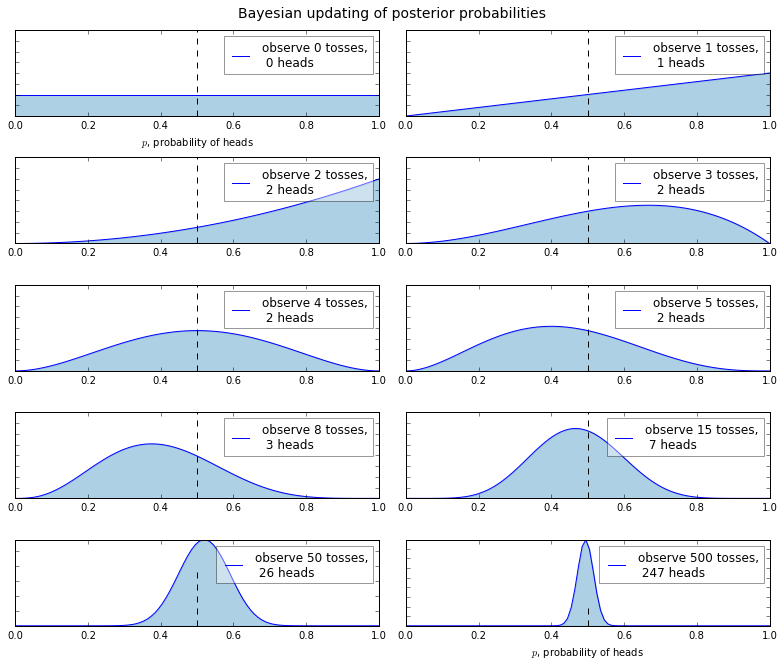

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

# For the already prepared, I'm using Binomial's conj. prior.
for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials) / 2, 2, k + 1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials) - 1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities",
             y=1.02,
             fontsize=14)

plt.tight_layout()

_______

## Quick recap of Probability Distributions

We can consider 3 classes of random variables $Z$:
    
-   **$Z$ is discrete**. 

Expected value $E(Z) = \Sigma x_i p_i$, for result $x$ and probability $p$. 

Distribution of $Z$ is called the *probability mass function* - the probability that $Z$ takes the value $k$, $P(Z=k)$. The most common probability mass function is the *Poisson distribution*:

$$P(Z = k) =\frac{ \lambda^k e^{-\lambda} }{k!}, \; \; k=0,1,2, \dots $$

$\lambda$ parameterizes the Poisson distribution, describing the shape. Usefully, the expected value of the Poisson distribution is equal to $\lambda$:
$$ E[Z] = \lambda$$

-   **$Z$ is continuous**. 

Expected value $E(Z) = \int x f(x) dx$ for probability density function $f(x)$

- **$Z$ is mixed**

### Worked example

>  You are given a series of daily text-message counts from a user of your system. The data, plotted over time, appears in the chart below. You are curious to know if the user's text-messaging habits have changed over time, either gradually or suddenly. How can you model this? (This is in fact my own text-message data. Judge my popularity as you wish.)

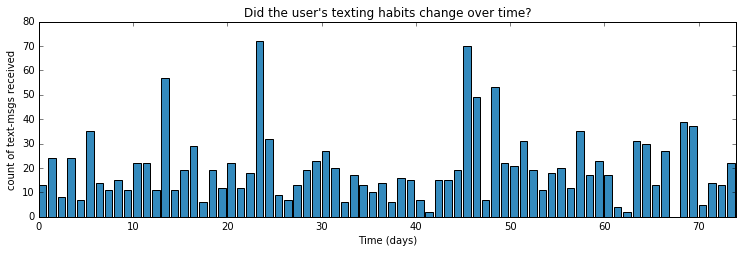

In [2]:
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

How should we model this? We have discrete data, so lets use a Poisson distribution. We denote day $i$'s text-message count by $C_i$,

$$ C_i \sim \text{Poisson}(\lambda)  $$

Now, we don't know what $\lambda$ is. Looking at the chart, we might suspect that at some point in the observations, $\lambda$ increases. We can state this mathematically,

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

We are now interested in inferring the unknowns $\lambda_1, \lambda_2$. What would be a good prior probability distribution for these?
$\lambda_{1,2}$, can be any positive number, so we want some form of continuous probability density function. Lets use the *exponential distribution*

$$f_Z(z | \alpha) = \alpha e^{-\alpha z }, \;\; z\ge 0$$



The expected value of random variable $z$, is 

$$ E[Z] = \frac{1}{\alpha}$$

What about $\tau$? it is tricky to pick when $\tau$ might have occured. Instead we can assign a uniform prior. Our overall prior distribution on the unknown variables is getting messy; we want $\lambda$, which in turn is described by distributions of $\lambda_1, \lambda_2, \tau$. Furthermore, $\lambda_1, \lambda_2$ are both parameterized by $\alpha$. 

We instead use PyMC, a Python library for performing Bayesian analysis.

### Introducing PyMC
We will model our problem using PyMC. This is known as *probabilistic programming*. It is probabilistic in the sense that we create probability models using programming variables. 

Lets dive in:

In [3]:
import pymc as pm 

alpha = 1 / count_data.mean() #From our earlier defenition of the expected value
                              #of the exponential distribution
    
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
    

We can then use these parameters to construct our structure of $\lambda$ itself.

In [4]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)
    out[:tau] = lambda_1  # lambda before tau is lambda1
    out[tau:] = lambda_2  # lambda after (and including) tau is lambda2
    return out

@pm.deterministic is a decorator that tells PyMC this is a deterministic function. That is, if the arguments were deterministic (which they are not), the output would be deterministic as well. Deterministic functions will be covered in Chapter 2.

Now lets create our $\lambda$ prior distribution:

In [5]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

The code below is explained in Chapter 3. It is known as *Markov Chain Monte Carlo*, which returns thousands or random variables from the posterior distributions of $\lambda_1, \lambda_2$ and $\tau$.

In [6]:
# Mysterious code to be explained in Chapter 3.
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 10.0 sec

In [7]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

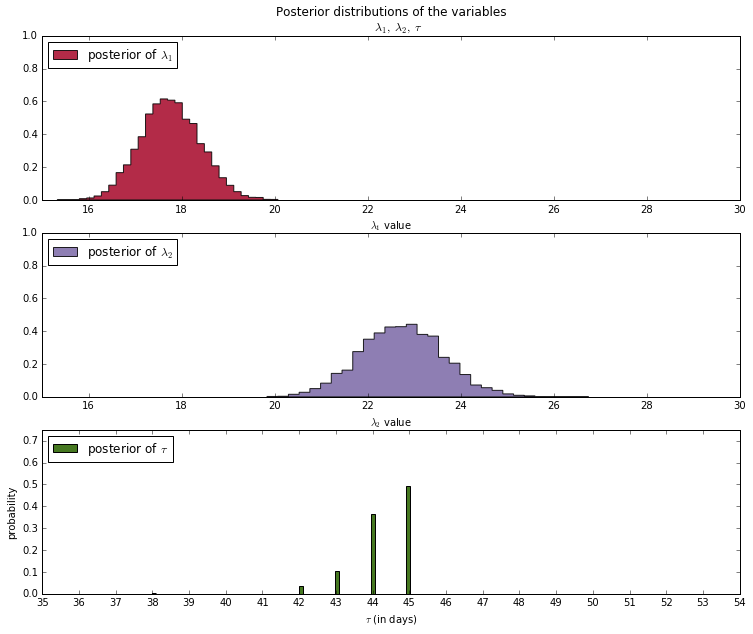

In [8]:
figsize(12.5, 10)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

So now we have some distributions of $\lambda_1, \lambda_2$ and $\tau$. These represent our belief in the possible values these parameters can take. We can now answer the question, what is the expected number of texts at day $t, 0 \leq t \leq 70$? This is equivalent to asking *what is the expected value of $\lambda$ at time $t$*?

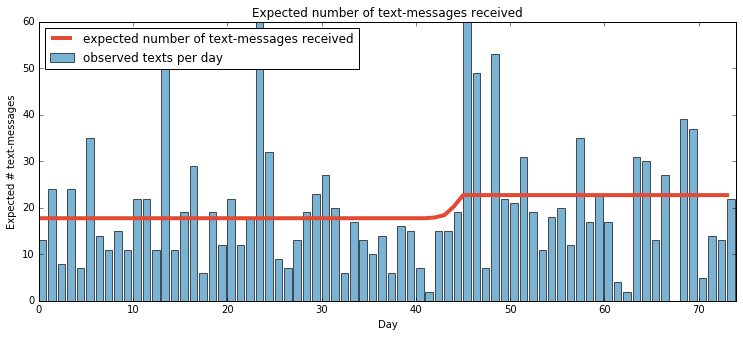

In [9]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):

    ix = day < tau_samples

    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

This analysis seems to support that the user's behaviour did change, rahter suddenly

### Exercises
1\.  Using `lambda_1_samples` and `lambda_2_samples`, what is the mean of the posterior distributions of $\lambda_1$ and $\lambda_2$?

In [13]:
print (np.mean(lambda_1_samples))
print (np.mean(lambda_2_samples))

17.7584487269
22.7316017731


Do these seem reasonable from looking at the histograms? Yes.

2\.  What is the expected percentage increase in text-message rates? `hint:` compute the mean of `lambda_1_samples/lambda_2_samples`. Note that this quantity is very different from `lambda_1_samples.mean()/lambda_2_samples.mean()`.

In [16]:
print (np.mean(lambda_2_samples/lambda_1_samples))

1.28171650014


i.e. ~ a 28% increase

3\. What is the mean of $\lambda_1$ **given** that we know $\tau$ is less than 45.  That is, suppose we have been given new information that the change in behaviour occurred prior to day 45. What is the expected value of $\lambda_1$ now? (You do not need to redo the PyMC part. Just consider all instances where `tau_samples < 45`.)

In [20]:
lambda_1_cropped = []
for i in range(len(tau_samples)):
    if tau_samples[i] < 45:
        #Only get the lambdas where tau < 45
        lambda_1_cropped.extend([lambda_1_samples[i]])

print (np.mean(lambda_1_cropped))

17.7623110292
